# **Pattern Recognition Course (Fall 2024) - Assignment #4**

**Due date**: 10th of Bahman 1403

**Objective**: 
-   Design a SVM  classifier with RBF, linear, and polynomial kernels to predict customer's age bucket based on spending, salary, location etc. This classification could offer insights for targeted marketing.
-   Observe the effect of normalization of the result

**Dataset**: 1000 customers of a retail store in New York. 


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV


# 1. Data Collection

In [33]:
df = pd.read_csv(
    "retailMarketing(Original).csv",
    sep=",",
    index_col=0,
)# ignoring first column as an index

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 0 to 999
Data columns (total 19 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Age              1000 non-null   object
 1   Salary           1000 non-null   int64 
 2   Children         1000 non-null   int64 
 3   AmountSpent      1000 non-null   int64 
 4   Gender_Female    1000 non-null   int64 
 5   Gender_Male      1000 non-null   int64 
 6   OwnHome_Own      1000 non-null   int64 
 7   OwnHome_Rent     1000 non-null   int64 
 8   Married_Married  1000 non-null   int64 
 9   Married_Single   1000 non-null   int64 
 10  Location_Close   1000 non-null   int64 
 11  Location_Far     1000 non-null   int64 
 12  History_High     1000 non-null   int64 
 13  History_Low      1000 non-null   int64 
 14  History_Medium   1000 non-null   int64 
 15  Catalogs_6       1000 non-null   int64 
 16  Catalogs_12      1000 non-null   int64 
 17  Catalogs_18      1000 non-null   int64 

,Age,Salary,Children,AmountSpent,Gender_Female,Gender_Male,OwnHome_Own,OwnHome_Rent,Married_Married,Married_Single,Location_Close,Location_Far,History_High,History_Low,History_Medium,Catalogs_6,Catalogs_12,Catalogs_18,Catalogs_24
0,Old,47500,0,755,1,0,1,0,0,1,0,1,0,1,0,1,0,0,0
1,Middle,63600,0,1318,0,1,0,1,0,1,1,0,0,0,1,1,0,0,0
2,Young,13500,0,296,1,0,0,1,0,1,1,0,0,0,1,0,0,1,0
3,Middle,85600,1,2436,0,1,1,0,1,0,1,0,1,0,0,0,0,1,0
4,Middle,68400,0,1304,1,0,1,0,0,1,1,0,1,0,0,0,1,0,0


# Stage 2: Data Preprocessing

Multiple columns in the dataset branched off of a single field and are mutually exclusive hence exhibit redundancy.
It seems that Catalogs used to be a categorical feature and went thru one hot encoding whether the extra cardinality proves to be insightful, is yet to be investigated

In [34]:
df["Gender"] = df["Gender_Female"]  # Encode Female as 1, Male as 0
df["OwnHome"] = df["OwnHome_Own"]  # Encode OwnHome_Own as 1, rent as 0
df["Married"] = df["Married_Married"]  # Encode Married_Married as 1, single as 0
df["History"] = np.select(
    [df["History_Low"] == 1, df["History_Medium"] == 1, df["History_High"] == 1],
    [0, 1, 2],
    default=-1,  # Fallback for potential errors (e.g., all zeros)
)

df["Catalogs"] = np.select(
    [
        df["Catalogs_6"] == 1,
        df["Catalogs_12"] == 1,
        df["Catalogs_18"] == 1,
        df["Catalogs_24"] == 1,
    ],
    [6, 12, 18, 24],
    default=-1,  # Fallback for potential errors (e.g., all zeros)
)

df = df.drop(
    columns=[
        "Gender_Female",
        "Gender_Male",
        "OwnHome_Rent",
        "OwnHome_Own",
        "Married_Married",
        "Married_Single",
        "Location_Far",
        "History_Low",
        "History_Medium",
        "History_High",
        "Catalogs_6",
        "Catalogs_12",
        "Catalogs_18",
        "Catalogs_24",
    ]
)

label_encoder = LabelEncoder()
df["Age"] = label_encoder.fit_transform(df["Age"])

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   Age             1000 non-null   int64
 1   Salary          1000 non-null   int64
 2   Children        1000 non-null   int64
 3   AmountSpent     1000 non-null   int64
 4   Location_Close  1000 non-null   int64
 5   Gender          1000 non-null   int64
 6   OwnHome         1000 non-null   int64
 7   Married         1000 non-null   int64
 8   History         1000 non-null   int64
 9   Catalogs        1000 non-null   int64
dtypes: int64(10)
memory usage: 85.9 KB


,Age,Salary,Children,AmountSpent,Location_Close,Gender,OwnHome,Married,History,Catalogs
0,1,47500,0,755,0,1,1,0,0,6
1,0,63600,0,1318,1,0,0,0,1,6
2,2,13500,0,296,1,1,0,0,1,18
3,0,85600,1,2436,1,0,1,1,2,18
4,0,68400,0,1304,1,1,1,0,2,12


> Distance-based methods (like SVM and KNN) will be dominated by larger-magnitude features, leading to poor decision boundaries.

**Standardization (Z-Score Scaling)**: Transforms features to have zero mean and unit standard deviation.
$$
X' = \frac{X - \mu}{\sigma}
$$

Standardization characteristics:
- Changes the shape of the distribution.
- Less sensitive to outliers compared to min-max scaling.

In [40]:
scaler = StandardScaler()
df[['Salary', 'AmountSpent']] = scaler.fit_transform(df[['Salary', 'AmountSpent']])

df[['Salary','AmountSpent']].info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Index: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Salary       1000 non-null   float64
 1   AmountSpent  1000 non-null   float64
dtypes: float64(2)
memory usage: 23.4 KB


,Age,Salary,Children,AmountSpent,Location_Close,Gender,OwnHome,Married,History,Catalogs
0,1,-0.273862,0,-0.481548,0,1,1,0,0,6
1,0,0.250005,0,0.105717,1,0,0,0,1,6
2,2,-1.380164,0,-0.960331,1,1,0,0,1,18
3,0,0.965847,1,1.271903,1,0,1,1,2,18
4,0,0.406189,0,0.091114,1,1,1,0,2,12


# Stage 3: Feature Extraction

In [35]:
label_multi = 'Age'
class_labels = ["Middle", "Old", "Young"]
x = df.drop(columns=[label_multi])  
y = df[label_multi]

# Stage 3: Training

## SVM optimization 

$$
\begin{align*}
&\text{Maximize the margin while correctly classifying points. This is formulated as:} \\\\
&\min_{w,b,\xi} \frac{1}{2}||w||^2 + C\sum_{i=1}^{N}\xi_i \\\\
&\text{Subject to:} \\\\
&y_i(\mathbf{w}^\top\phi(\mathbf{x}_i) + b) \geq 1 - \xi_i, \quad \xi_i \geq 0 \quad \forall i \\\\
&\textbf{Components:} \\
&1. \frac{1}{2}||w||^2: \text{ Minimizing this ensures a large margin.} \\
&2. \sum_{i=1}^{N}\xi_i: \text{ Slack variables ($\xi_i$) allow for misclassification.} \\
&3. C: \text{ Regularization parameter balancing margin size vs. misclassification.}
\end{align*}
$$

## Create train test segments

In [36]:
X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.30, random_state=0
)

## 3.1 Linear kernel

$$
K(\mathbf{x}_i, \mathbf{x}_j) = \mathbf{x}_i^\top \mathbf{x}_j
$$
This is equivalent to computing the dot product of two feature vectors.


**Impact on SVM:**
- Linear decision boundary: The hyperplane is a straight line (in 2D) or a flat plane (in 3D).
- No feature mapping: The linear kernel does not transform the data into a higher-dimensional space.

In [14]:
svm_lin = SVC(kernel="linear")
svm_lin.fit(X_train, y_train)

SVC(kernel='linear')

## 3.2 Poly kernel

$$
K(\mathbf{x}_i, \mathbf{x}_j) = (\mathbf{x}_i^\top \mathbf{x}_j + c)^d
$$

-   d: Degree of the polynomial.
    -   Low d (e.g., 2 or 3): Captures simpler nonlinear relationships.
    -   High d: Models more complex relationships but may overfit.
-   c: A constant controlling the influence of higher-order terms.
    -   Affects the decision boundary’s flexibility and influences the model’s smoothness.

### 3.2.1 Tuning the best params

In [17]:
poly_param_grid = {"C": [0.01, 0.1, 1], "degree": [1, 3, 5, 7], "kernel": ["poly"]}

grid_search_poly = GridSearchCV(SVC(), poly_param_grid, cv=5, return_train_score=True)
grid_search_poly.fit(X_train, y_train)

poly_tuned_results = pd.DataFrame(grid_search_poly.cv_results_)
poly_tune_report = poly_tuned_results[
    ["param_C", "param_degree", "mean_test_score", "std_test_score", "mean_train_score"]
]

print(poly_tune_report)
print("Best parameters:", grid_search_poly.best_params_)
print(f"Best score: {grid_search_poly.best_score_:.2%}")


    param_C  param_degree  mean_test_score  std_test_score  mean_train_score
0      0.01             1         0.498571        0.002857          0.498571
1      0.01             3         0.498571        0.002857          0.498571
2      0.01             5         0.500000        0.004518          0.499643
3      0.01             7         0.535714        0.007825          0.543571
4      0.10             1         0.498571        0.002857          0.498571
5      0.10             3         0.508571        0.008330          0.512500
6      0.10             5         0.537143        0.016537          0.548571
7      0.10             7         0.547143        0.015386          0.557857
8      1.00             1         0.677143        0.025714          0.685714
9      1.00             3         0.642857        0.021189          0.649643
10     1.00             5         0.587143        0.025314          0.590714
11     1.00             7         0.581429        0.013997          0.605000

### 3.2.2 Training Poly 

In [18]:
svm_poly_tuned = SVC(**grid_search_poly.best_params_)
svm_poly_tuned.fit(X_train, y_train)

SVC(C=1, degree=1, kernel='poly')

## 3.3 RBF kernel

$$
K(\mathbf{x}_i, \mathbf{x}_j) = \exp \left( -\frac{\|\mathbf{x}_i - \mathbf{x}_j\|^2}{2\sigma^2} \right)
$$
$$
\text{Here, } \sigma \text{ (or } \gamma = \frac{1}{2\sigma^2} \text{) controls the width of the Gaussian function.}
$$

-   Large gamma: Focuses on points very close to the hyperplane, making the decision boundary highly flexible but prone to overfitting.
-   Small gamma: Creates a smoother decision boundary, possibly underfitting the data.


**Impact on SVM:**
- Nonlinear decision boundary: The RBF kernel maps data into an infinite-dimensional space, allowing it to handle complex, non-linear relationships.
- Localized influence: Data points closer to each other in feature space have higher similarity, which makes the decision boundary flexible.


### 3.3.1 Tuning the parameters

In [21]:
rbf_param_grid = {"C": [0.01, 0.1, 1], "gamma": [0.01, 0.1, 1], "kernel": ["rbf"]}

grid_search_rbf = GridSearchCV(SVC(), rbf_param_grid, cv=5, return_train_score=True)
grid_search_rbf.fit(X_train, y_train)

rbf_tuned_results = pd.DataFrame(grid_search_rbf.cv_results_)
rbf_tune_report = rbf_tuned_results[
    ["param_C", "param_gamma", "mean_test_score", "std_test_score", "mean_train_score"]
]

print(rbf_tune_report)
print("Best parameters:", grid_search_rbf.best_params_)
print(f"Best score: {grid_search_rbf.best_score_:.2%}")


   param_C  param_gamma  mean_test_score  std_test_score  mean_train_score
0     0.01         0.01         0.498571        0.002857          0.498571
1     0.01         0.10         0.498571        0.002857          0.498571
2     0.01         1.00         0.498571        0.002857          0.498571
3     0.10         0.01         0.511429        0.016660          0.515000
4     0.10         0.10         0.628571        0.011952          0.637143
5     0.10         1.00         0.498571        0.002857          0.498571
6     1.00         0.01         0.700000        0.023905          0.709286
7     1.00         0.10         0.722857        0.022315          0.803214
8     1.00         1.00         0.685714        0.025153          0.938571
Best parameters: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
Best score: 72.29%


### 3.3.2 Training RBF 

In [22]:
svm_rbf_tuned = SVC(**grid_search_rbf.best_params_)
svm_rbf_tuned.fit(X_train, y_train)

SVC(C=1, gamma=0.1)

# Stage 4: Testing

## 4.1 Linear SVM

Linear Kernel Accuracy: 75.3%


<Axes: >

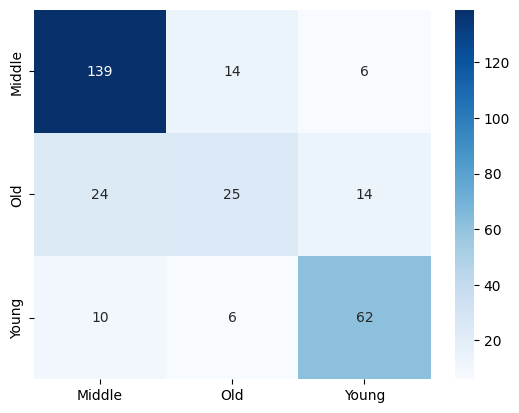

In [31]:
y_pred_lin = svm_lin.predict(X_test)
print(
    f"Linear Kernel Accuracy: {accuracy_score(y_test, y_pred_lin):.1%}"
)

lin_cm = confusion_matrix(y_test, y_pred_lin)
sns.heatmap(
    data=lin_cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_labels,
    yticklabels=class_labels,
)

## 4.2 Poly SVM

Poly Kernel Accuracy: 68.00%


<Axes: >

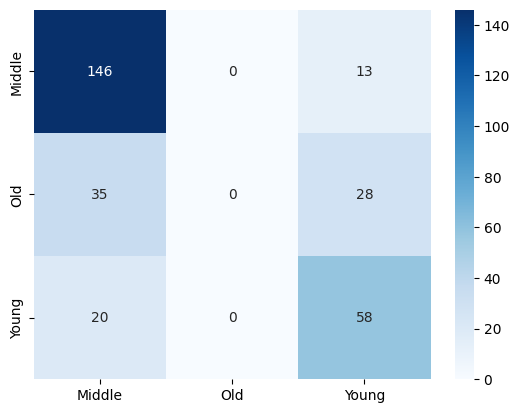

In [30]:
y_pred_poly = svm_poly_tuned.predict(X_test)
print(
    f"Poly Kernel Accuracy: {accuracy_score(y_test, y_pred_poly):.2%}"
)

poly_cm = confusion_matrix(y_test, y_pred_poly)
sns.heatmap(
    data=poly_cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_labels,
    yticklabels=class_labels,
)

## 4.3 RBF SVM

RBF Kernel Accuracy: 73.00%


<Axes: >

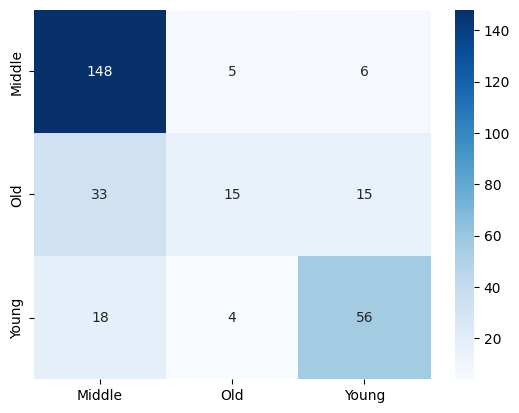

In [29]:
y_pred_rbf = svm_rbf_tuned.predict(X_test)
print(f"RBF Kernel Accuracy: {accuracy_score(y_test, y_pred_rbf):.2%}")

rbf_cm = confusion_matrix(y_test, y_pred_rbf)
sns.heatmap(
    data=rbf_cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_labels,
    yticklabels=class_labels,
)

# Stage 6: Observing standardization in effect

In [39]:
def eval():
    X_train, X_test, y_train, y_test = train_test_split(
        x, y, test_size=0.30, random_state=0
    )

    print(">>>> WITHOUT StandardScaler<<<<<")
    for i in range(2):
        if i == 1:
            scaler = StandardScaler()
            X_train[["Salary", "AmountSpent"]] = scaler.fit_transform(
                X_train[["Salary", "AmountSpent"]]
            )
            X_test[["Salary", "AmountSpent"]] = scaler.fit_transform(
                X_test[["Salary", "AmountSpent"]]
            )
            print("\n>>>> With StandardScaler <<<<<")

        # linear kernel
        svm_lin = SVC(kernel="linear")
        svm_lin.fit(X_train, y_train)
        y_pred_lin = svm_lin.predict(X_test)
        print(f"Linear Kernel Accuracy: {accuracy_score(y_test, y_pred_lin):.1%}")

        print("---Poly")
        poly_param_grid = {
            "C": [0.01, 0.1, 1],
            "degree": [1, 3, 5, 7],
            "kernel": ["poly"],
        }
        grid_search_poly = GridSearchCV(
            SVC(), poly_param_grid, cv=5, return_train_score=True
        )
        grid_search_poly.fit(X_train, y_train)
        svm_poly_tuned = SVC(**grid_search_poly.best_params_)
        svm_poly_tuned.fit(X_train, y_train)
        y_pred_poly = svm_poly_tuned.predict(X_test)
        print("Poly Best parameters:", grid_search_poly.best_params_)
        print(f"Poly Train Best score: {grid_search_poly.best_score_:.2%}")
        print(f"Poly Kernel Accuracy: {accuracy_score(y_test, y_pred_poly):.2%}")

        print("---RBF")
        rbf_param_grid = {
            "C": [0.01, 0.1, 1],
            "gamma": [0.01, 0.1, 1],
            "kernel": ["rbf"],
        }
        grid_search_rbf = GridSearchCV(
            SVC(), rbf_param_grid, cv=5, return_train_score=True
        )
        grid_search_rbf.fit(X_train, y_train)
        y_pred_rbf = svm_rbf_tuned.predict(X_test)
        print("RBF Best parameters:", grid_search_rbf.best_params_)
        print(f"RBF Training Best score: {grid_search_rbf.best_score_:.2%}")
        print(f"RBF Kernel Accuracy: {accuracy_score(y_test, y_pred_rbf):.2%}")

eval()

>>>> WITHOUT StandardScaler<<<<<
Linear Kernel Accuracy: 68.3%
---Poly
Poly Best parameters: {'C': 1, 'degree': 1, 'kernel': 'poly'}
Poly Train Best score: 70.43%
Poly Kernel Accuracy: 71.00%
---RBF
RBF Best parameters: {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}
RBF Training Best score: 50.14%
RBF Kernel Accuracy: 53.00%

>>>> With StandardScaler <<<<<
Linear Kernel Accuracy: 75.3%
---Poly
Poly Best parameters: {'C': 1, 'degree': 1, 'kernel': 'poly'}
Poly Train Best score: 67.43%
Poly Kernel Accuracy: 67.67%
---RBF
RBF Best parameters: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
RBF Training Best score: 72.29%
RBF Kernel Accuracy: 72.67%
